In [1]:
from torch.nn.modules.loss import MSELoss
import torch.nn as nn
import numpy as np
import pandas as pd
import torch
from torchvision import transforms

In [2]:
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_pickle('/home/niell_lab/data/freely_moving_ephys/batch_files/093021/pooled_ephys_population_update_100121.pickle')

In [4]:
this_unit = 300
rf = np.reshape(df1['hf1_wn_spike_triggered_average'].iloc[this_unit],tuple(df1['hf1_wn_sta_shape'].iloc[this_unit]))

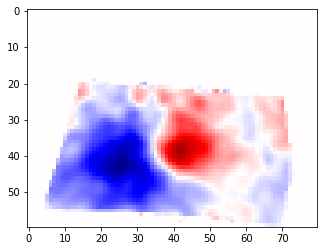

In [5]:
crange = np.max(np.abs(rf))*1.2
if crange<0.25:
    crange=0.25
plt.imshow(rf, vmin=-crange, vmax=crange, cmap='seismic')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
from torch import optim

In [52]:
class GaborModel(nn.Module):
    def __init__(self, imgsize=(60,80), init_params=None):
        super().__init__()
        
        self.use_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        if init_params is None:
            self.sigma = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
            self.theta = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
            self.Lambda = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
            self.psi = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
            self.gamma = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
            self.xoffset = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
            self.yoffset = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        else:
            init_params = dict([key, float(val)] for key, val in init_params.items())
            
            self.sigma = nn.Parameter(torch.tensor(init_params['sigma'], requires_grad=True, dtype=torch.float))
            self.theta = nn.Parameter(torch.tensor(init_params['theta'], requires_grad=True, dtype=torch.float))
            self.Lambda = nn.Parameter(torch.tensor(init_params['lambda'], requires_grad=True, dtype=torch.float))
            self.psi = nn.Parameter(torch.tensor(init_params['psi'], requires_grad=True, dtype=torch.float))
            self.gamma = nn.Parameter(torch.tensor(init_params['gamma'], requires_grad=True, dtype=torch.float))
            self.xoffset = nn.Parameter(torch.tensor(init_params['xoffset'], requires_grad=True, dtype=torch.float))
            self.yoffset = nn.Parameter(torch.tensor(init_params['yoffset'], requires_grad=True, dtype=torch.float))
            
        self.clipfreq = 5
        self.clip_params()    
        
        self.img_height = torch.tensor(imgsize[0], dtype=torch.float).to(self.use_device)
        self.img_width = torch.tensor(imgsize[1], dtype=torch.float).to(self.use_device)
        
        self.to(self.use_device)
        
        self.double()
        
    def clip_params(self):
        with torch.no_grad():
            self.sigma.clamp_(4, 20)
            self.theta.clamp_(0, torch.tensor(np.pi)*2)
            self.Lambda.clamp_(0.1, 1)
            self.psi.clamp_(0, torch.tensor(np.pi)*2)
            self.gamma.clamp_(0.5, 4)
            self.xoffset.clamp_(-0.3, 0.3)
            self.yoffset.clamp_(-0.3, 0.3)
    
    def generate_gabor(self):
        
        center = (self.yoffset*self.img_height, self.xoffset*self.img_width)
        Lambda = self.Lambda*200

        sigma_x = self.sigma
        sigma_y = self.sigma / self.gamma

        ymax, xmax = (self.img_height, self.img_width)
        xmax, ymax = (xmax - 1)/2, (ymax - 1)/2
        xmin = -xmax
        ymin = -ymax
        (y, x) = torch.meshgrid(torch.arange(ymin, ymax+1).to(self.use_device), torch.arange(xmin, xmax+1).to(self.use_device))
        
        x_theta = (x-center[0]) * torch.cos(self.theta) + (y-center[1]) * torch.sin(self.theta)
        y_theta = -(x-center[0]) * torch.sin(self.theta) + (y-center[1]) * torch.cos(self.theta)

        gb = torch.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * torch.cos(2 * torch.tensor(np.pi) / Lambda * x_theta + self.psi)
    
        return gb
    
    def fit(self, rf_input, epochs=50000, diagnostic_history=False):
        """ Fit gabor filter to true recetive field.

        Parameters:
        rf_input (np.array): 2D receptive field of a single neuron
        epochs (int): epochs over which to train model
        lr (float): learning rate

        Returns:
        gabor (np.array): solution as 2D array
        params (dict): dictionary of best gabor filter parameters
        """
        
        history = np.zeros([int(np.ceil(epochs/self.clipfreq)), 8])
        
        actual_rf = torch.tensor(rf_input, dtype=torch.double).to(self.use_device)
        
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        
        for t in range(epochs):
            gabor = self.generate_gabor()
            loss = loss_fn(gabor, actual_rf)
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
            
#             if t % self.clipfreq == 0:
#                 self.clip_params()
            
            if t % self.clipfreq == 0 and diagnostic_history is True:
                history[int(np.ceil(t/self.clipfreq)),:] = np.array([float(loss.item()),
                                                                     float(self.sigma.cpu().detach()),
                                                                     float(self.theta.cpu().detach()),
                                                                     float(self.Lambda.cpu().detach()),
                                                                     float(self.psi.cpu().detach()),
                                                                     float(self.gamma.cpu().detach()),
                                                                     float(self.xoffset.cpu().detach()),
                                                                     float(self.yoffset.cpu().detach())])
                
                
        params = {'sigma':float(self.sigma.cpu().detach()), 'theta':float(self.theta.cpu().detach()),
                  'lambda':float(self.Lambda.cpu().detach()), 'psi':float(self.psi.cpu().detach()),
                  'gamma':float(self.gamma.cpu().detach()), 'xoffset':float(self.xoffset.cpu().detach()),
                  'yoffset':float(self.yoffset.cpu().detach())}
        
        return gabor.cpu().detach().numpy(), params, history
    

In [382]:
test_params = {'sigma':4, 'theta':0, 'lambda':0.1, 'psi':2.1, 'gamma':2.5, 'xoffset':0, 'yoffset':0}

In [388]:
model = GaborModel(init_params=test_params).to(device)
fit1, params1 = model.fit(rf)

In [391]:
params1

{'sigma': 3.999583656874225,
 'theta': -0.000400021346159324,
 'lambda': 1.0004024399464804,
 'psi': 1.4530414833370102,
 'gamma': 3.6305408747424237,
 'xoffset': -0.3004000014671002,
 'yoffset': -0.30040000326703886}

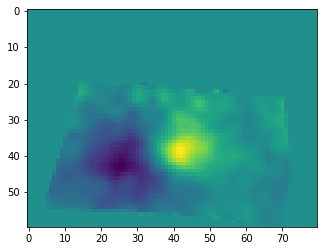

In [390]:
plt.imshow(rf)

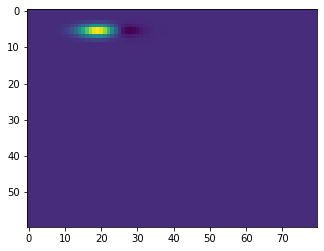

In [389]:
plt.imshow(fit1)

In [396]:
model.state_dict()

OrderedDict([('sigma', tensor(3.9996, device='cuda:0', dtype=torch.float64)),
             ('theta', tensor(-0.0004, device='cuda:0', dtype=torch.float64)),
             ('Lambda', tensor(1.0004, device='cuda:0', dtype=torch.float64)),
             ('psi', tensor(1.4530, device='cuda:0', dtype=torch.float64)),
             ('gamma', tensor(3.6305, device='cuda:0', dtype=torch.float64)),
             ('xoffset',
              tensor(-0.3004, device='cuda:0', dtype=torch.float64)),
             ('yoffset',
              tensor(-0.3004, device='cuda:0', dtype=torch.float64))])

In [398]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [399]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.005,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'params': [0, 1, 2, 3, 4, 5, 6]}]}

In [272]:
model = GaborModel((60,80)).to(device)

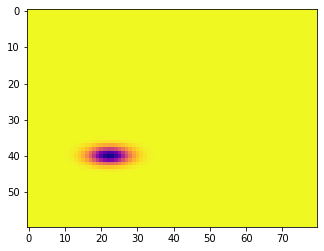

In [277]:
plt.imshow(model.generate_gabor().cpu().detach().numpy(), cmap='plasma')

(-0.5, 79.5, 59.5, -0.5)

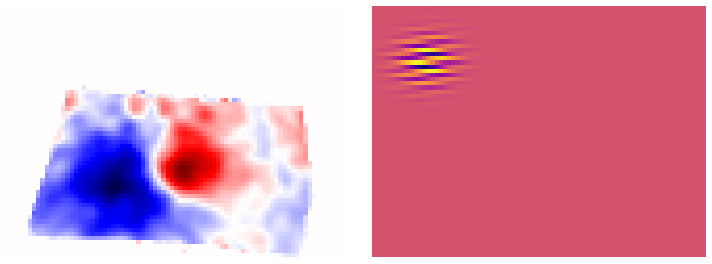

In [53]:
model = GaborModel((60,80)).to(device)
plt.subplots(1,2,figsize=(10,4))
plt.subplot(1,2,1)
rf_range = np.max(np.abs(rf))
plt.imshow(rf, cmap='seismic', vmin=-rf_range, vmax=rf_range)
plt.axis('off')
plt.subplot(1,2,2)
fit, params, history = model.fit(rf, diagnostic_history=True)
plt.imshow(fit, cmap='plasma')
plt.tight_layout()
plt.axis('off')

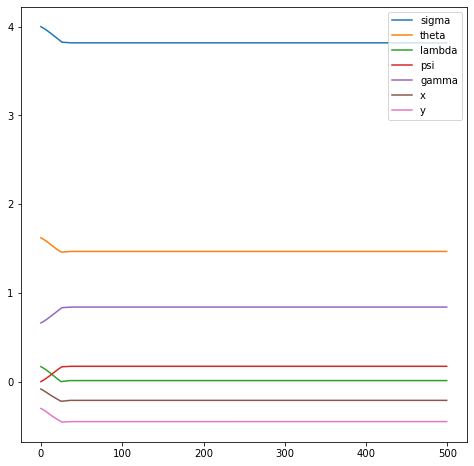

In [54]:
plt.figure(figsize=(8,8))
plt.plot(history[:500,1:])
plt.legend(['sigma','theta','lambda','psi','gamma','x','y'])

In [275]:
params

{'sigma': Parameter containing:
 tensor([3.9996], device='cuda:0', dtype=torch.float64, requires_grad=True),
 'theta': Parameter containing:
 tensor([-0.0004], device='cuda:0', dtype=torch.float64, requires_grad=True),
 'lambda': Parameter containing:
 tensor([1.0004], device='cuda:0', dtype=torch.float64, requires_grad=True),
 'psi': Parameter containing:
 tensor([2.1637], device='cuda:0', dtype=torch.float64, requires_grad=True),
 'gamma': Parameter containing:
 tensor([2.5715], device='cuda:0', dtype=torch.float64, requires_grad=True),
 'xoffset': Parameter containing:
 tensor([0.1287], device='cuda:0', dtype=torch.float64, requires_grad=True),
 'yoffset': Parameter containing:
 tensor([-0.3000], device='cuda:0', dtype=torch.float64, requires_grad=True)}